# CS133 Term Project – Video Game Sales

Group 13  
Kaulan Serzhanuly, Shruthi Raghavachary, Haitham Assaf (017558515)

This notebook combines:
- Exploratory data analysis (scatter + categorical plots)
- One interactive Plotly visualization
- A machine learning pipeline to predict game sales category


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline


In [5]:
from google.colab import files
import pandas as pd
import io

print("Please upload 'Video_Games_Sales_as_at_22_Dec_2016.csv':")
uploaded = files.upload()

filename = "Video_Games_Sales_as_at_22_Dec_2016.csv"
if filename in uploaded:
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
else:
    filename = next(iter(uploaded))
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

if 'Year_of_Release' in df.columns:
    df.rename(columns={'Year_of_Release': 'Year'}, inplace=True)

df.dropna(subset=['Year', 'Global_Sales', 'Genre', 'Platform'], inplace=True)

df['Year'] = df['Year'].astype(int)

df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

print("Data Loaded & Cleaned Successfully.")
print(df.info())
print(df.head())

Please upload 'Video_Games_Sales_as_at_22_Dec_2016.csv':


Saving Video_Games_Sales_as_at_22_Dec_2016.csv to Video_Games_Sales_as_at_22_Dec_2016.csv
Data Loaded & Cleaned Successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 16448 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16448 non-null  object 
 1   Platform      16448 non-null  object 
 2   Year          16448 non-null  int64  
 3   Genre         16448 non-null  object 
 4   Publisher     16416 non-null  object 
 5   NA_Sales      16448 non-null  float64
 6   EU_Sales      16448 non-null  float64
 7   JP_Sales      16448 non-null  float64
 8   Other_Sales   16448 non-null  float64
 9   Global_Sales  16448 non-null  float64
 10  Critic_Score  7983 non-null   float64
 11  Critic_Count  7983 non-null   float64
 12  User_Score    7463 non-null   float64
 13  User_Count    7463 non-null   float64
 14  Developer     9907 non-null   object 
 15  Rating        9769 non-null   obje

## Q1: What is the distribution of Global Sales?
We visualize the distribution to see if sales are normally distributed or skewed.

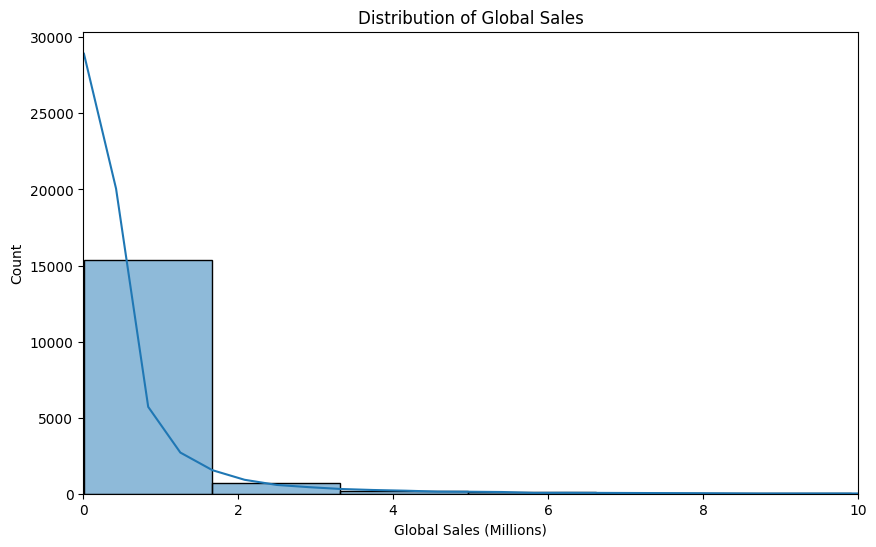

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Global_Sales'], kde=True, bins=50)
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (Millions)')
plt.xlim(0, 10)
plt.show()

## Q2: How do sales vary across top platforms? (Categorical Plot)
Using `sns.catplot` to view distributions and outliers.

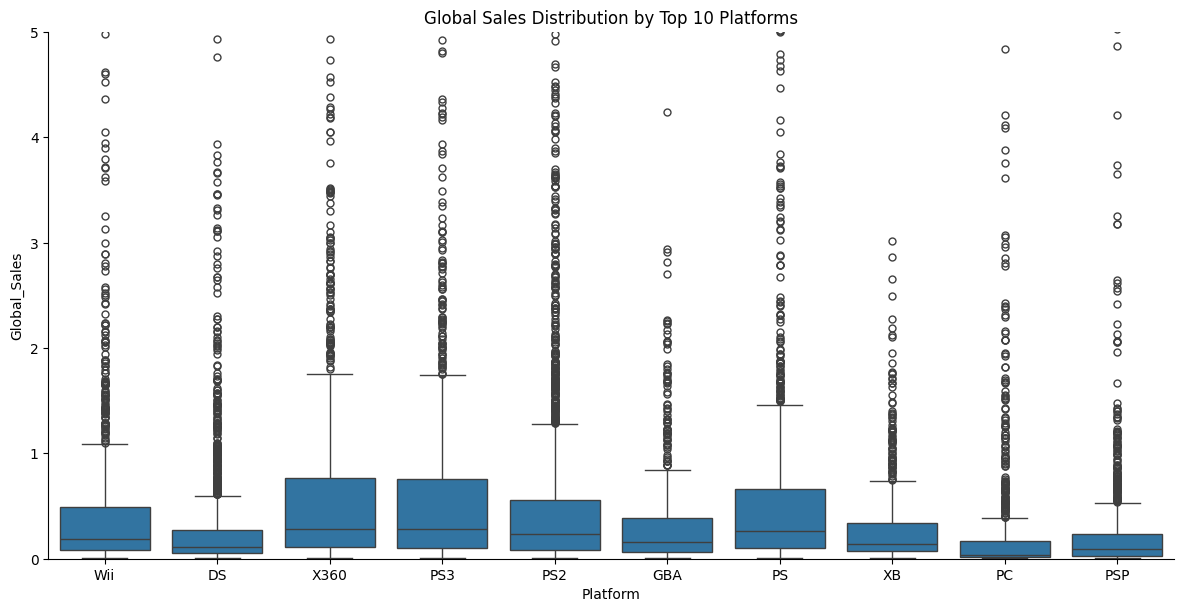

In [7]:
top_platforms = df['Platform'].value_counts().head(10).index
df_filtered = df[df['Platform'].isin(top_platforms)]

sns.catplot(
    data=df_filtered,
    x="Platform",
    y="Global_Sales",
    kind="box",
    height=6,
    aspect=2
)
plt.title("Global Sales Distribution by Top 10 Platforms")
plt.ylim(0, 5)
plt.show()


## Q3: Is there a relationship between User Score and Global Sales? (Scatter Plot)
We use a scatter plot to see if higher-rated games sell better.

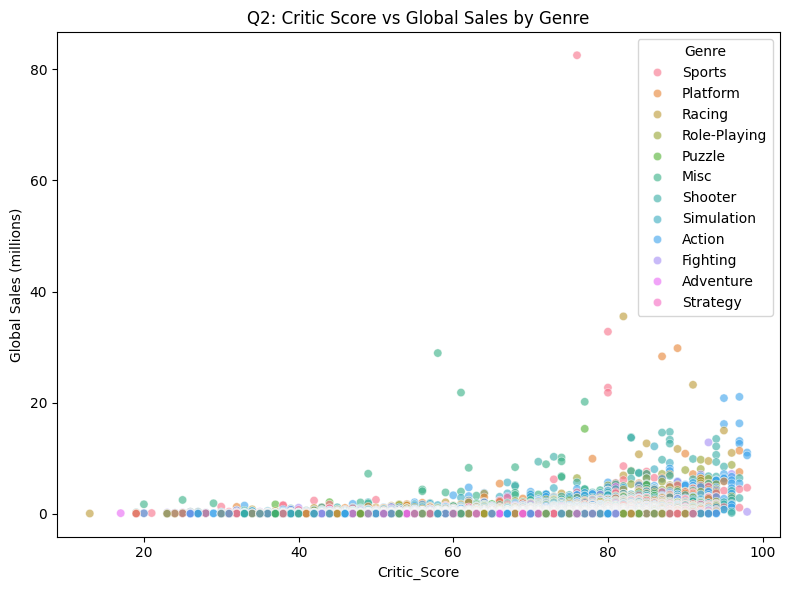

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Critic_Score",
    y="Global_Sales",
    hue="Genre",
    alpha=0.6
)
plt.title("Q2: Critic Score vs Global Sales by Genre")
plt.ylabel("Global Sales (millions)")
plt.tight_layout()
plt.show()


## Q4: How have total sales changed over time? (Time Series)
Using `groupby` to aggregate sales by year.

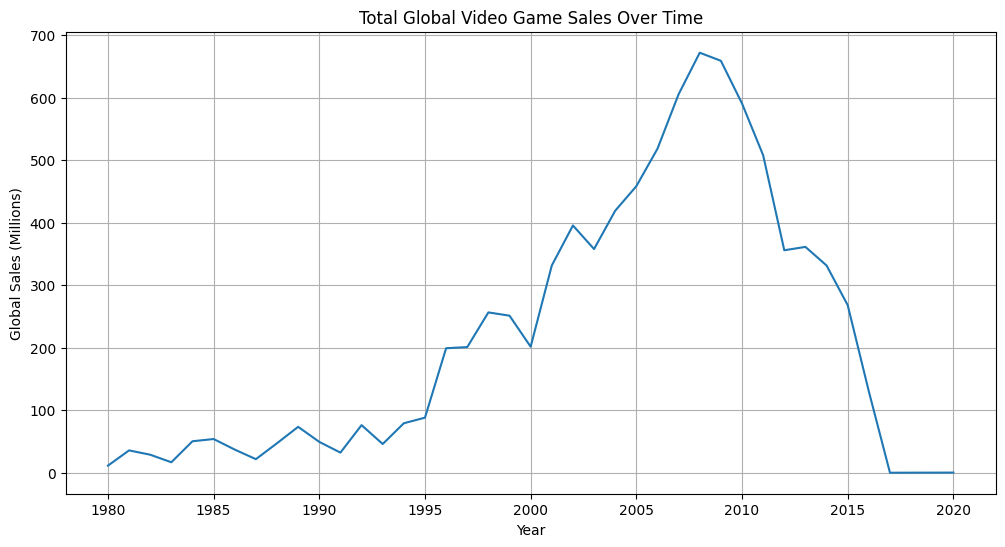

In [9]:
yearly_sales = df.groupby('Year')['Global_Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_sales, x='Year', y='Global_Sales')
plt.title("Total Global Video Game Sales Over Time")
plt.ylabel("Global Sales (Millions)")
plt.grid(True)
plt.show()

## Q5: Correlation between NA and EU Sales (Joint Plot)
Using `sns.jointplot` with hexagonal bins to handle data density.

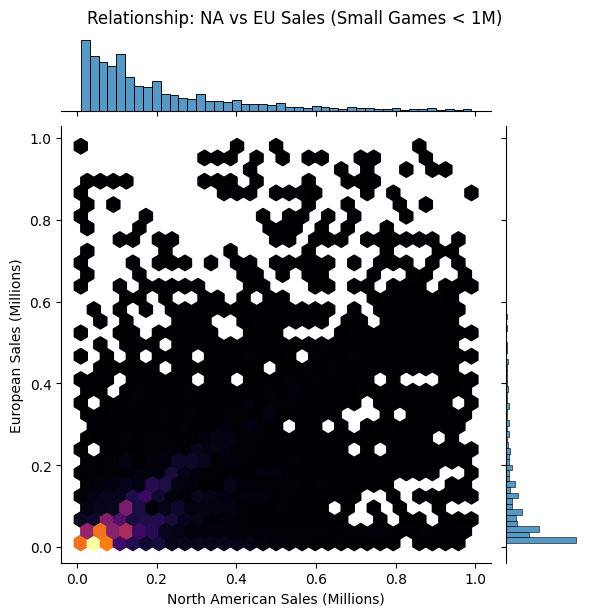

In [10]:
df_hex = df[
    (df['NA_Sales'] > 0) & (df['NA_Sales'] < 1.0) &
    (df['EU_Sales'] > 0) & (df['EU_Sales'] < 1.0)
]

g = sns.jointplot(
    data=df_hex,
    x="NA_Sales",
    y="EU_Sales",
    kind="hex",
    gridsize=30,
    cmap='inferno',
    mincnt=1
)


g.fig.suptitle("Relationship: NA vs EU Sales (Small Games < 1M)", y=1.02)
g.set_axis_labels("North American Sales (Millions)", "European Sales (Millions)")

plt.show()

## Interactive Plot: Sales Trends by Genre
Using `plotly.express` We restrict the view to the top 5 genres.

In [11]:
top_genres = df['Genre'].value_counts().head(5).index
df_interactive = df[df['Genre'].isin(top_genres)].groupby(['Year', 'Genre'])['Global_Sales'].sum().reset_index()

fig = px.line(
    df_interactive,
    x="Year",
    y="Global_Sales",
    color="Genre",
    title="Interactive Sales Trends for Top 5 Genres",
    labels={"Global_Sales": "Total Sales (Millions)"}
)
fig.show()

## Machine Learning Pipeline
**Goal:** Predict if a game will be a "Hit" (Sales > 0.5 Million).
**Strategy:**
1. **Prepare Data:** Create target variable 'Is_Hit', handle missing values, and encode categorical data.
2. **Split:** 80% Train, 20% Test.
3. **Model Selection:** Compare Logistic Regression, Decision Tree, and Random Forest.

In [13]:
df_ml = df[df['Year'] >= 2000].copy()


df_ml['Is_Hit'] = (df_ml['Global_Sales'] > 0.5).astype(int)

features = ['Platform', 'Genre', 'Year']
X = df_ml[features]
y = df_ml['Is_Hit']

categorical_features = ['Platform', 'Genre']
numerical_features = ['Year']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}


model_performance = {}
cv_results = {}

print("--- 5-Fold Cross-Validation on Training Set ---")
best_model_name = None
best_cv_score = -1.0
best_model = None

for name, model in models.items():

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


    scores = cross_val_score(clf, X_train, y_train, cv=5)
    cv_results[name] = scores

    mean_score = scores.mean()
    std_score = scores.std()


    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    model_performance[name] = test_acc

    print(f"\nModel: {name}")
    print(f"Cross-validation accuracy: {mean_score:.4f} (+/- {std_score:.4f})")
    print(f"Test accuracy:            {test_acc:.4f}")

    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_model_name = name
        best_model = model

print(f"\nBest model based on cross-validation: {best_model_name} (mean CV accuracy = {best_cv_score:.4f})")

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

final_pipeline.fit(X_train, y_train)
y_pred_final = final_pipeline.predict(X_test)


--- 5-Fold Cross-Validation on Training Set ---

Model: Logistic Regression
Cross-validation accuracy: 0.7793 (+/- 0.0003)
Test accuracy:            0.7786

Model: Decision Tree
Cross-validation accuracy: 0.7642 (+/- 0.0036)
Test accuracy:            0.7706

Model: Random Forest
Cross-validation accuracy: 0.7605 (+/- 0.0060)
Test accuracy:            0.7665

Best model based on cross-validation: Logistic Regression (mean CV accuracy = 0.7793)


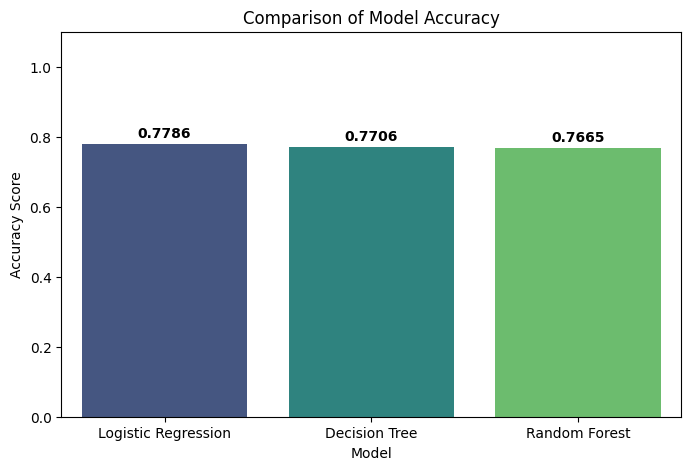

In [14]:
scores_df = pd.DataFrame(list(model_performance.items()), columns=['Model', 'Accuracy'])

plt.figure(figsize=(8, 5))

sns.barplot(data=scores_df, x='Model', y='Accuracy', hue='Model', palette='viridis', legend=False)

plt.ylim(0, 1.1)
plt.title("Comparison of Model Accuracy")
plt.ylabel("Accuracy Score")

for index, row in scores_df.iterrows():
    plt.text(index, row.Accuracy + 0.02, f'{row.Accuracy:.4f}', color='black', ha="center", fontdict={'weight': 'bold'})

plt.show()

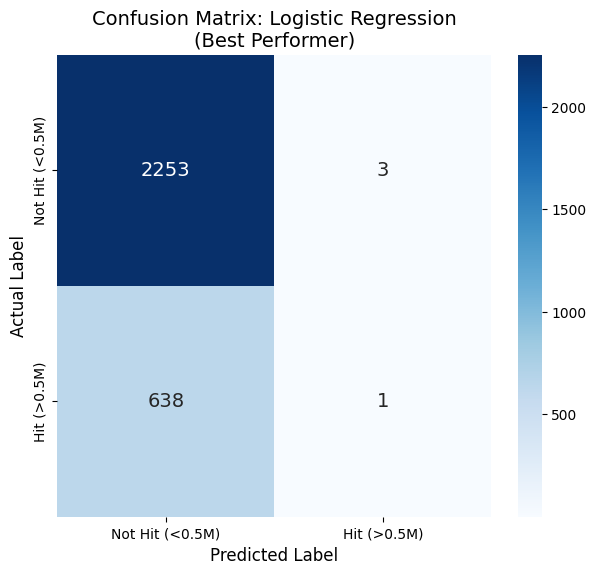


Classification report for best model on the test set:
              precision    recall  f1-score   support

     Not Hit       0.78      1.00      0.88      2256
         Hit       0.25      0.00      0.00       639

    accuracy                           0.78      2895
   macro avg       0.51      0.50      0.44      2895
weighted avg       0.66      0.78      0.68      2895



In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    annot_kws={"size": 14},
    xticklabels=['Not Hit (<0.5M)', 'Hit (>0.5M)'],
    yticklabels=['Not Hit (<0.5M)', 'Hit (>0.5M)']
)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.title(f'Confusion Matrix: {best_model_name}\n(Best Performer)', fontsize=14)
plt.show()

print("\nClassification report for best model on the test set:")
print(classification_report(y_test, y_pred_final, target_names=['Not Hit', 'Hit']))
